In [1]:
### code to generate the data set

import pdb
import numpy as np
import pandas as pd

## membership status
years      = ['2014', '2015', '2016', '2017', '2018']
userStatus = ['bronze', 'silver', 'gold', 'inactive']

userYears = np.random.choice(years, 1000, p = [0.1, 0.1, 0.15, 0.30, 0.35])
userStats = np.random.choice(userStatus, 1000, p = [0.5, 0.3, 0.1, 0.1])

yearJoined = pd.DataFrame({'yearJoined': userYears,
                           'userStats': userStats})

## email behavior
NUM_EMAILS_SENT_WEEKLY = 3 ## constant variable

## types of behavior
def never_opens(period_rng):
    return []

def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

def open_rate_with_factor_change(period_rng, fac):

    if len(period_rng) < 1 :
        return []
    
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    try:
        n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
        num_opened = np.zeros(len(period_rng))
        for pd in range(0, len(period_rng), 2):        
            num_opened[pd:(pd + 2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p * fac), 0)
    except:
        num_opened[pd] = np.random.binomial(n, p, 1)
    for t in times:
        num_opened[t] = 0
    return num_opened

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))
    
def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week))     + " days" )   + \
           pd.Timedelta(str(np.random.choice(hours_of_day))     + " hours" )  + \
           pd.Timedelta(str(np.random.choice(minute_of_hour))   + " minutes") + \
           pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds")
    
## donation behavior
def produce_donations(period_rng, user_behavior, num_emails, use_id, user_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    user_has = np.random.choice(donation_amounts)
        
    user_gives = num_emails  / (NUM_EMAILS_SENT_WEEKLY * len(period_rng)) * user_has
    user_gives_idx = np.where(user_gives >= donation_amounts)[0][-1]
    user_gives_idx = max(min(user_gives_idx, len(donation_amounts) - 2), 1)
    
    num_times_gave = np.random.poisson(2) * (2018 - user_join_year)
    
    times = np.random.randint(0, len(period_rng), num_times_gave)

    donations = pd.DataFrame({'user': [], 'amount': [], 'timestamp': []})
    for n in range(num_times_gave):
        
        donations = donations.append(pd.DataFrame({'user': [use_id],
                                       'amount': [donation_amounts[user_gives_idx + \
                                                  np.random.binomial(1, .3)]], 
                                       'timestamp': [str(period_rng[times[n]].start_time + random_weekly_time_delta())]}))

    if donations.shape[0] > 0:
        donations = donations[donations.amount != 0]
    return donations
    

## run it
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
user_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])
                                        
rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')
emails = pd.DataFrame({'user': [], 'week': [], 'emailsOpened':[]})
donations = pd.DataFrame({'user': [], 'amount': [], 'timestamp': []})

for idx in range(yearJoined.shape[0]):
    ## randomly generate the date when a user would have joined
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + \
                pd.Timedelta(str(np.random.randint(0, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
    
    ## user should not receive emails or make donations before joining
    ## thank you to Murray M Gillin for reporting errata and suggesting this correction
    user_rng = rng[rng.start_time > join_date]    
    
    if len(user_rng) < 1:
        continue

    info = user_behaviors[idx](user_rng)

    if len(info) == len(user_rng):
        emails = emails.append(pd.DataFrame({'user': [idx] * len(info),
                                    'week': [str(r.start_time) for r in user_rng],
                                    'emailsOpened': info}))

    donations = donations.append(produce_donations(user_rng, user_behaviors[idx],
                                                    sum(info), idx, join_date.year))



## get rid of zero donations and zero emails
emails = emails[emails.emailsOpened != 0]
yearJoined.index.name = 'user'

yearJoined.to_csv('data/year_joined.csv', index = False)
donations.to_csv( 'data/donations.csv',   index = False)
emails.to_csv(    'data/emails.csv',      index = False)


PermissionError: [Errno 13] Permission denied: 'data/year_joined.csv'

In [2]:
emails_df = pd.read_csv('data/emails.csv')
emails.head()

,user,week,emailsOpened
0,2.0,2018-05-14 00:00:00,2.0
1,2.0,2018-05-21 00:00:00,3.0
2,2.0,2018-05-28 00:00:00,2.0
0,3.0,2017-03-13 00:00:00,2.0
1,3.0,2017-03-20 00:00:00,3.0


In [4]:
import matplotlib.pyplot as plt

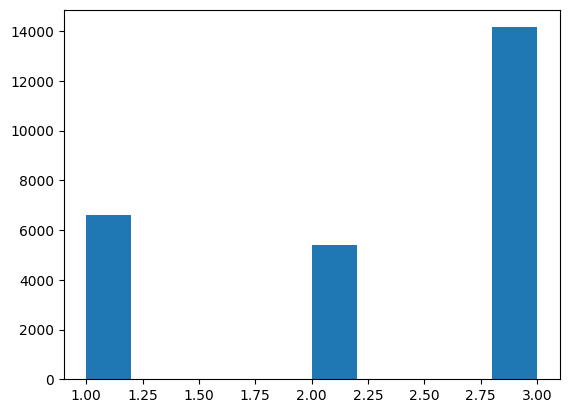

In [8]:
plt.hist(emails_df.emailsOpened);

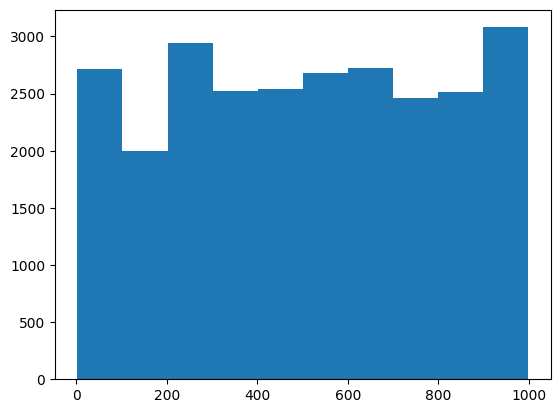

In [9]:
plt.hist(emails_df.user);

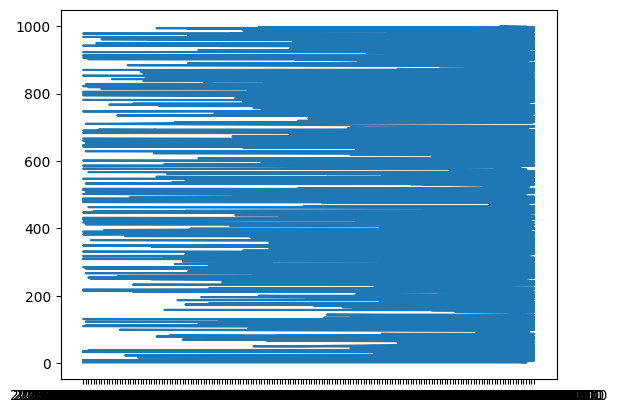

In [11]:
plt.plot(emails_df.week,emails_df.user );